# **PyPSA Curtailment Emulator**

This notebook first calculates the parameters based on existing PyPSA-Eur scenarios, which we then use afterwards to evaluate the skill of the emulator at different combinations of wind, solar, short-duration and long-duration electricity storage. 

In [3]:
from scripts.pypsa_curtailment_emulator import *
from scripts.curtailment_equations import *
from scripts.plotting import mesh_color_2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext autoreload
%autoreload 2

fs = 15
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True

Explore which scenarios are available:

In [4]:
RDIR = "calculated_metrics" # directory with the results of the PyPSA runs (.csv files)

scens_list = [x for x in os.listdir(RDIR + '/') if x.startswith("new_")]
print(scens_list)

['new_base', 'new_base_co2_lim', 'new_flipped_merit_order', 'new_full_sectors', 'new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_H2_demand', 'new_H2_demand_co2_lim', 'new_heating_demand', 'new_heating_demand_co2_lim', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission', 'new_transmission_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim', 'new_transport', 'new_transport_co2_lim']


The suffix "co2_lim" in the scenario name indicates that a Europe-aggregate CO2-emissions limit of 5% relative to 1990-levels has been applied. If the suffix is not included, no CO2-emissions limit has been defined.

Group scenarios by category (e.g., collecting all scenarios that allow for storage capacity expansion in the same list):

In [5]:
scens_series = pd.Series(scens_list)

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ power system ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for transmission expansion:
scens_w_transmission = scens_series.loc[scens_series.str.contains("transmission")].to_list()

# scenarios that allow for long-duration storage deployment: 
scens_w_ldes = scens_series.loc[scens_series.str.contains("LDES")].to_list()

# scenarios that allow for short-duration storage deployment:
scens_w_sdes = scens_series.loc[scens_series.str.contains("SDES")].to_list()

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ sector-coupling ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for sector-coupling with the heating sector:
scens_w_heating = scens_series.loc[scens_series.str.contains("heating")].to_list()

# scenarios that allow for sector-coupling with the land transport sector:
scens_w_transport = scens_series.loc[scens_series.str.contains("transport")].to_list()

# scenarios that allow for sector-coupling with the industry sector:
scens_w_industry = scens_series.loc[scens_series.str.contains("industry")].to_list()

print("scenarios with SDES: ", scens_w_sdes)
print("scenarios with LDES: ", scens_w_ldes)
print("scenarios with transmission: ", scens_w_transmission)

scenarios with SDES:  ['new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']
scenarios with LDES:  ['new_full_sectors_SDES_LDES', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']
scenarios with transmission:  ['new_transmission', 'new_transmission_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']


# **Creating the PyPSA Curtailment Emulator**

The Excel file "data/pypsa_curtailment_emulator.xlsx" contains the equations representing the renewable curtailment at a given share of wind, solar, battery, and long-duration energy storage. 

First, we will update the parameters used in the equations. We can do this, making the parameterization dependent on a scenario with or without a CO2 emissions limit ("new_base" and "new_base_co2_lim").

In [30]:
file_path = 'data/PyPSA_curtailment_emulator.xlsx' # location of pypsa emulator excel file
base_case = "new_base_co2_lim" # name of base curtailment scenario
SDES_case = "new_SDES_co2_lim" # name of the scenario representing the curtailment impact of SDES
LDES_case = "new_SDES_LDES_co2_lim" # name of the scenario representing the curtailment impact of LDES
transmission_case = 'new_transmission_SDES_LDES_co2_lim' # electricity transmission expansion scenario

# energy efficiencies assumed in PyPSA-Eur:
efficiencies = {"LDES":0.48,
                "SDES":0.9,
                "transmission":1,
                } 

tech_labels = {"LDES":"absolute dispatch", # variable name as it is used in the calculated metrics
                "SDES":"absolute dispatch", # variable name as it is used in the calculated metrics
                "transmission":"volume",# variable name as it is used in the calculated metrics
                }
                
scenarios = {"base":base_case,

             "LDES":
                {"wind":[base_case,SDES_case,LDES_case],
                 "solar":[SDES_case,SDES_case,LDES_case]},
                 
             "SDES":
                {"solar":[base_case,base_case,SDES_case],
                 "wind":[base_case,base_case,SDES_case]},

            "transmission":
                {"solar":[base_case,LDES_case,transmission_case],
                 "wind":[base_case,LDES_case,transmission_case]},

            #  "heating":
            #     {"wind":[],
            #      "solar":[]},
            
            #  "transport":
            #     {"wind":[],
            #      "solar":[]},

            #  "industry":
            #     {"wind":[],
            #      "solar":[]}

                }

Update parameters acc. to the specified scenarios (if not, set update_parameters to False which keeps the existing parameters):


In [83]:
update_parameters = True

if update_parameters:
    create_emulator(scenarios,
                    RDIR, 
                    file_path,
                    efficiencies,
                    tech_labels,
                    update_excel_file=True, # if True, updates the excel file with the results of the PyPSA runs
                                            # Note that the Excel file only updates parameters of wind, solar, LDES, and SDES.
                    ) 

Wind curtailment successfully parameterized! Proceeding to solar curtailment...
Solar curtailment successfully parameterized! Proceeding to technology term...
LDES impact on wind curtailment successfully parameterized!
SDES impact on wind curtailment successfully parameterized!
transmission impact on wind curtailment successfully parameterized!
LDES impact on solar curtailment successfully parameterized!
SDES impact on solar curtailment successfully parameterized!
transmission impact on solar curtailment successfully parameterized!
Parameterization done!


# **Testing the PyPSA Curtailment Emulator**

In [93]:
def run_pypsa_emulator_python(renewable,demand, primary_resource, secondary_resource, act_techs):
    primary_term_sum, secondary_term_sum = include_base_curtailment(renewable,primary_resource,secondary_resource,demand)
    tech_term_sum = include_tech_term(act_techs.keys(),act_techs,renewable,primary_resource,secondary_resource,demand)
        
    total_curtailment_d = primary_term_sum + secondary_term_sum + sum(tech_term_sum.values()) # percentage of demand
    total_curtailment_r = total_curtailment_d/primary_resource*100 # percentage of resources
    
    return total_curtailment_d.item(), total_curtailment_r.item()

In [67]:
def test_pypsa_emulator_python(primary_res,
                               secondary_res,
                               renewable,
                               demand, 
                               act_techs):
    curtailment_d = {}
    curtailment_r = {}
    for primary_resource in primary_res:
        for secondary_resource in secondary_res:
            if primary_resource + secondary_resource <= 130:
                curt_d,curt_r = run_pypsa_emulator_python(renewable,demand, primary_resource, secondary_resource, act_techs)
                curtailment_d[secondary_resource,primary_resource] = curt_d
                curtailment_r[secondary_resource,primary_resource] = curt_r

    return curtailment_d, curtailment_r

Define the scenario for the estimation of the curtialment based on the renewable penetration of wind energy and solar PV, as well as the level of storage dispatch from short-duration (SDES) and long-duration energy storage (LDES). 

Note that the current version of this repository uses an Excel sheet which might lead to long computation time since it reads and writes to the file in every iteration.

In [84]:
results_path = "results/" # directory at which curtailment estimates will be stored
method = "Python" # "Python" or "Excel"
curtailment_type = "resources" # "demand" or "resources
overwrite = True # Whether existing files should be overwritten (True) or not (False)

demand = 100 # electricity demand on transmission and distribution level
wind_res = np.arange(10,100,10) # wind resources (in percentage of demand)
solar_res = np.arange(10,100,10) # solar resources (in percentage of demand)
ldes = 0 # activity of long-duration storage (in percentage of demand)
sdes = 0 # activity of short-duration storage (in percentage of demand)
transmission = 200 # transmission expansion (in percentage of existing transmission volume)

# features from sector-coupling (to be added):
# heat_demand = 0 # heat demand (in percentage of demand)
# h2_demand = 0 # hydrogen demand (in percentage of demand)
# EVs = 0 # electricity demand of EVs (in percentage of demand)
# heat_pump = 0 # heat pump activity (in percentage of demand)

Evaluate the curtailment emulator at the specified scenarios:

In [102]:
act_techs = {"ldes":ldes,
             "sdes":sdes,
             "transmission":transmission,}
N = len(wind_res)*len(solar_res) # number of wind-solar combinations
filename_wind = "wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + "_series.csv"
filename_solar = "solar_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + "_series.csv"

file_exist = os.path.isfile(results_path + filename_wind) and os.path.isfile(results_path + filename_solar)
if file_exist and overwrite == False:
    print("Files exist. Reading .csv files...")
    wind_curtailment_series = pd.read_csv(results_path + filename_wind, index_col=[0,1])["0"]
    solar_curtailment_series = pd.read_csv(results_path + filename_solar, index_col=[0,1])["0"]
    print("done.")
else:
    if file_exist:
        print("Files exist. Overwriting .csv files...")
    else:
        print("Files do not exist. Creating new .csv files...")
    if method == "Excel":
        print("Using Excel method...")
        wind_curtailment_series, solar_curtailment_series = test_pypsa_emulator(file_path, 
                                                                                wind_res,solar_res,ldes,sdes, 
                                                                                curtailment_type=curtailment_type)
    elif method == "Python":
        print("Using Python method...")
        renewable = "wind"
        wind_curtailment_d, wind_curtailment_r = test_pypsa_emulator_python(wind_res,solar_res,renewable,demand, act_techs)

        renewable = "solar"
        solar_curtailment_d, solar_curtailment_r = test_pypsa_emulator_python(solar_res,wind_res,renewable,demand, act_techs)
        
        if curtailment_type == "demand":
            wind_curtailment_series = pd.Series(wind_curtailment_d).sort_index()
            solar_curtailment_series = pd.Series(solar_curtailment_d).reorder_levels([1,0]).sort_index()
        elif curtailment_type == "resources":
            wind_curtailment_series = pd.Series(wind_curtailment_r).sort_index()
            solar_curtailment_series = pd.Series(solar_curtailment_r).reorder_levels([1,0]).sort_index()

    wind_curtailment_series.to_csv("results/" + filename_wind)
    solar_curtailment_series.to_csv("results/" + filename_solar)

    print("done.")

Files exist. Overwriting .csv files...
Using Python method...
done.


# Visualize the estimated curtailment levels from the emulator

In [73]:
color_max_value = 70

Wind:

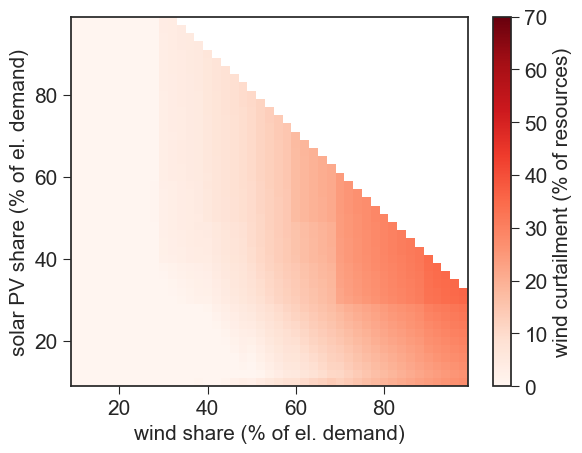

In [215]:
fig1, ax1, df1 = color_plot_2D(wind_curtailment_series, 
                               renewable = "wind", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/wind/wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

Solar:

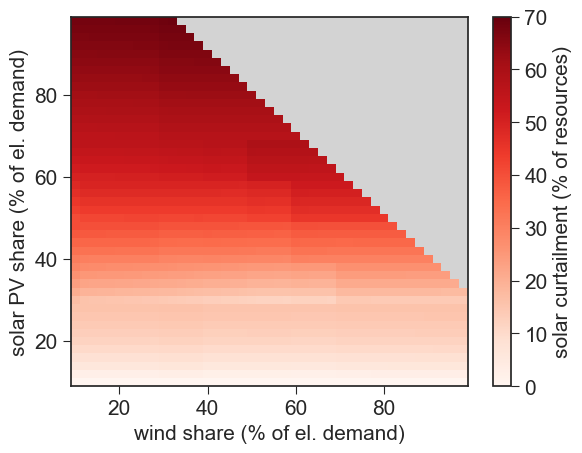

In [219]:
fig1, ax1, df1 = color_plot_2D(solar_curtailment_series, 
                               renewable = "solar", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/solar/solar_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

Estimated wind base curtailment:

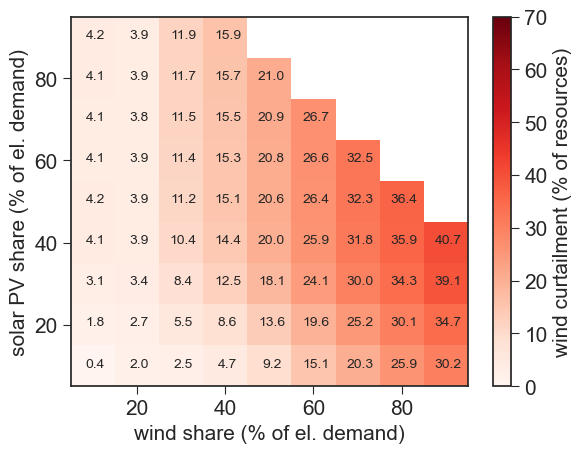

In [86]:
fig1, ax1, df1 = color_plot_2D(wind_curtailment_series, 
                               renewable = "wind", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/wind/wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

Estimated wind curtailment when including transmission expansion:

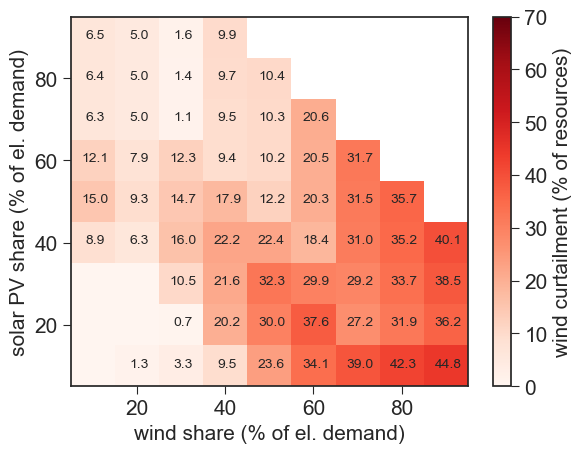

In [95]:
fig1, ax1, df1 = color_plot_2D(wind_curtailment_series, 
                               renewable = "wind", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/wind/wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

# Compare with the observed values in PyPSA-Eur

### Base curtailment

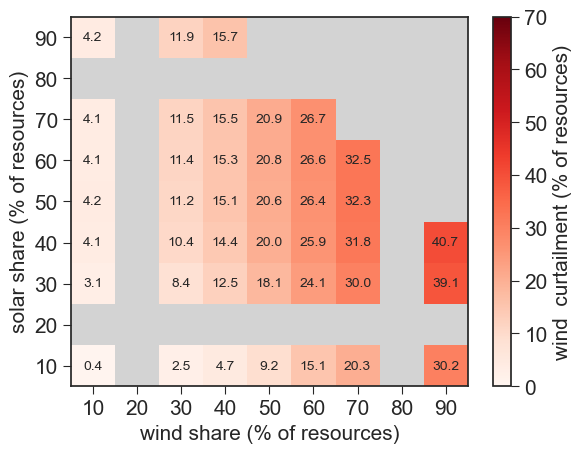

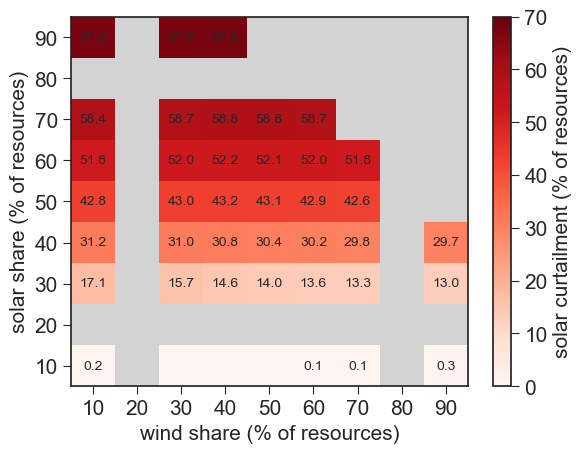

In [216]:
scens = [base_case]

variables = {"read":["wind curt", 
                    "solar curt",
                    "total demand"],
            "plot":["wind curt",
                    "solar curt"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[base_case,0].savefig("figures/wind/model_wind_curtailment_base_case_resources.png",
                bbox_inches="tight",
                dpi=300)

figs[base_case,1].savefig("figures/solar/model_solar_curtailment_base_case_resources.png",
                bbox_inches="tight",
                dpi=300)

### Technology activity

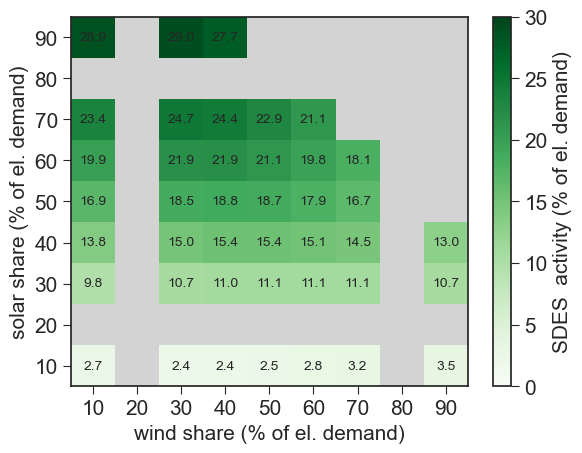

In [29]:
scens = [SDES_case]

variables = {"read":["SDES absolute dispatch","total demand"],
            "plot":["SDES absolute dispatch"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=30,
                              var = "activity",
                              norm_w_demand=True,
                              equidistant=True,
                              )

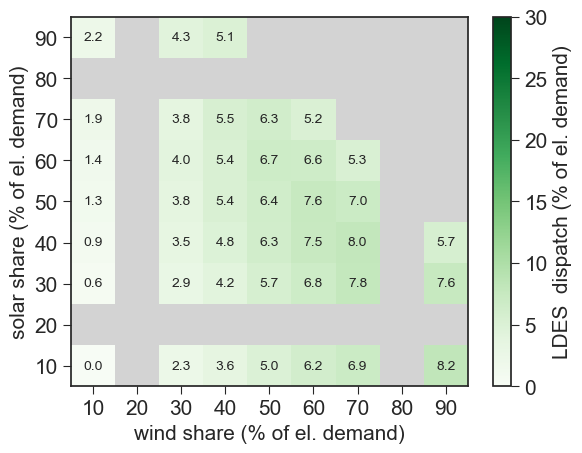

In [28]:
scens = [LDES_case]

variables = {"read":["LDES absolute dispatch","total demand"],
            "plot":["LDES absolute dispatch"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=30,
                              var = "activity",
                              norm_w_demand=True,
                              equidistant=True,
                              )

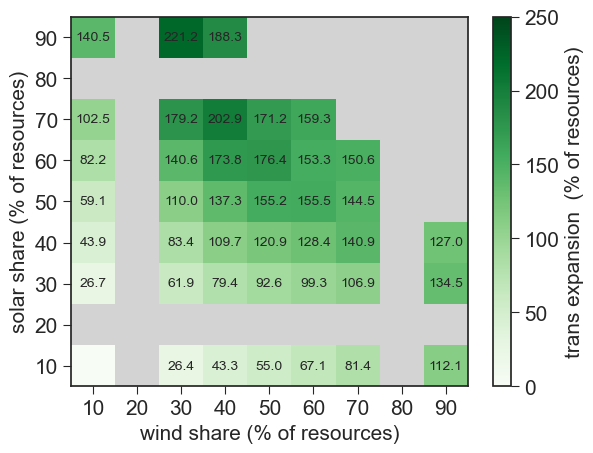

In [57]:
scens = [transmission_case]

variables = {"read":["transmission volume"],
            "plot":["transmission volume"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=250,
                              var = "expansion ",
                              norm_w_demand=False,
                              equidistant=True,
                              )

### Curtailment when including SDES

Note that when including the impact of storage, the results obtained with the linear estimation in the above, we have assessed the impact at a fixed level of storage for all wind-solar combinations. Here, when comparing with the results from PyPSA-Eur, the storage level differ across all wind-solar combinations since the storage capacity and dispatch were optimized in every wind-solar combination.

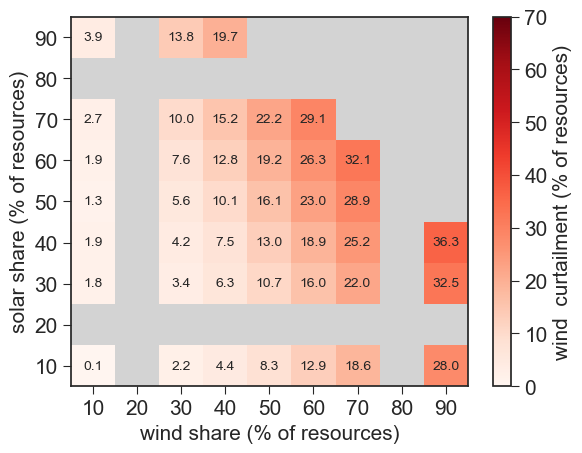

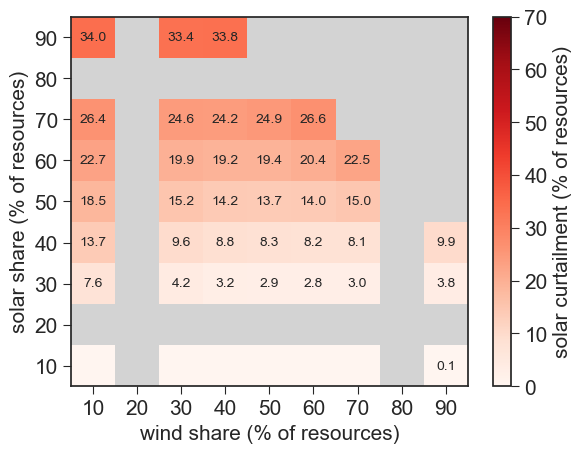

In [217]:
scens = [SDES_case]

variables = {"read":["wind curt", 
                    "solar curt",
                    "total demand"],
            "plot":["wind curt",
                    "solar curt"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[SDES_case,0].savefig("figures/wind/model_wind_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

figs[SDES_case,1].savefig("figures/solar/model_solar_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

### Curtailment when including LDES

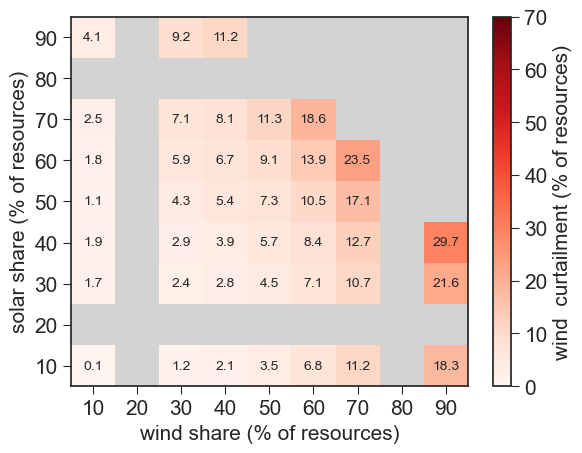

In [218]:
scens = [LDES_case]

variables = {"read":["wind curt", 
                #     "solar curt",
                    "total demand"],
            "plot":["wind curt",
                #     "solar curt",
                    ]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[LDES_case,0].savefig("figures/wind/model_wind_curtailment_LDES_case.png",
                bbox_inches="tight",
                dpi=300)

# Curtailment when including transmission expansion

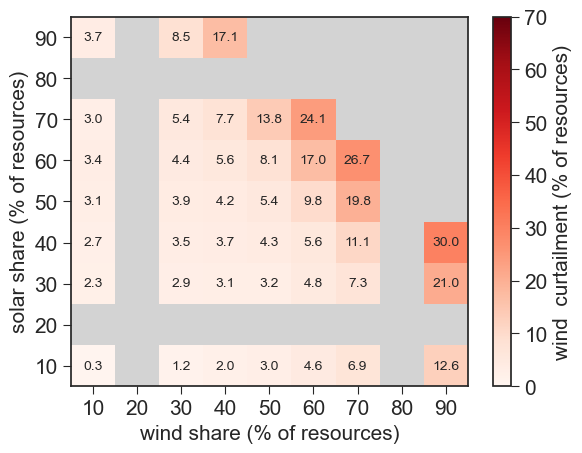

In [97]:
scens = [transmission_case]

variables = {"read":["wind curt", 
                    "total demand"],
            "plot":["wind curt",
                    ]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

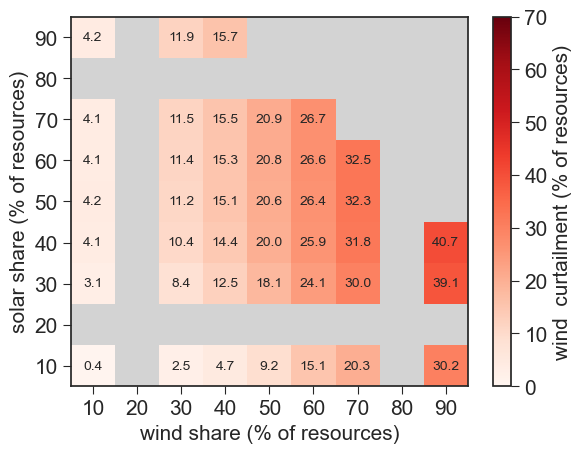

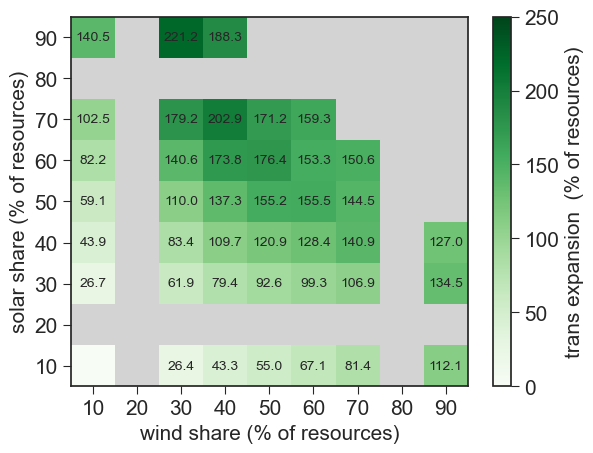

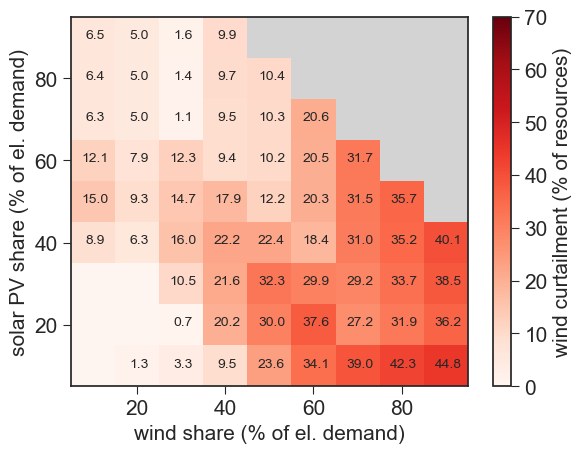